In [1]:
from minimaldit.minimaldit import MinimalDiT
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from schedulefree import AdamWScheduleFree

In [2]:
def preload_dataset(image_size=256, device="cuda"):
    """Preload and cache the entire dataset in GPU memory"""
    print("Loading and preprocessing dataset...")
    dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size), antialias=True),
        transforms.Lambda(lambda x: (x * 2) - 1)  # Scale to [-1, 1]
    ])

    # Process all images at once
    all_images = []
    for example in dataset:
        # The Pokemon dataset stores images in 'image' field
        img_tensor = transform(example['image'].convert('RGB'))
        all_images.append(img_tensor)

    # Stack all images into a single tensor and move to GPU
    images_tensor = torch.stack(all_images).to(device)
    print(f"Dataset loaded: {images_tensor.shape} ({images_tensor.element_size() * images_tensor.nelement() / 1024/1024:.2f} MB)")
    
    return TensorDataset(images_tensor)

In [3]:
# Preload dataset to GPU
img_size = 128
batch_size=32
device="cuda:0"
dataset = preload_dataset(image_size=img_size, device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=False)

Loading and preprocessing dataset...
Dataset loaded: torch.Size([833, 3, 128, 128]) (156.19 MB)


In [4]:
def train_flow_matching(
    dataloader,
    num_epochs=1000,
    batch_size=32,
    device="cuda",
    sigma_min=0.001,
    img_size=128,
    patch_size=16,
    dim=512,
    depth=6,
    heads=8,
    save_every=100
):
    # Initialize vector field model
    model = MinimalDiT(  # Direct DiT usage instead of VectorField wrapper
        img_size=img_size,
        patch_size=patch_size,
        in_channels=3,
        dim=dim,
        depth=depth,
        heads=heads
    ).to(device)
    
    # Initialize optimizer
    optimizer = AdamWScheduleFree(
        model.parameters(),
        lr=1e-4,
        warmup_steps=1000,
        weight_decay=0.01
    )
    optimizer.train()
    
    # Training loop
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            x1 = batch[0]
            batch_size = x1.shape[0]
            
            # Sample random times t ∈ [0,1]
            t = torch.rand(batch_size, device=device)
            timesteps = (t * 1000).long()
            
            # Sample noise
            x0 = torch.randn_like(x1)
            
            # Compute OT interpolation
            sigma_t = 1 - (1 - sigma_min) * t.reshape(-1, 1, 1, 1)
            mu_t = t.reshape(-1, 1, 1, 1) * x1
            x_t = sigma_t * x0 + mu_t
            
            # Get vector field prediction
            v_t = model(x_t)
            
            # Flow matching loss
            target = x1 - (1 - sigma_min) * x0
            loss = torch.mean((v_t - target) ** 2)
            
            # Optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint if loss improved
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_model.pt')
        
        # Regular checkpoint saving
        if epoch % save_every == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'checkpoint_epoch_{epoch}.pt')
    
    return model


config = {
    'num_epochs': 1000,
    'batch_size': batch_size,
    'device': device,
    'sigma_min': 0.001,
    'img_size': img_size,
    'patch_size': 16,
    'dim': 512,
    'depth': 6,
    'heads': 32,
    'save_every': 50000
}

# Start training
model = train_flow_matching(dataloader, **config)

Epoch 0, Average Loss: 1.9956
Epoch 1, Average Loss: 1.7362
Epoch 2, Average Loss: 1.5362
Epoch 3, Average Loss: 1.4261
Epoch 4, Average Loss: 1.3588
Epoch 5, Average Loss: 1.3109
Epoch 6, Average Loss: 1.2781
Epoch 7, Average Loss: 1.2647
Epoch 8, Average Loss: 1.2466
Epoch 9, Average Loss: 1.2337
Epoch 10, Average Loss: 1.2266
Epoch 11, Average Loss: 1.1961
Epoch 12, Average Loss: 1.1757
Epoch 13, Average Loss: 1.1581
Epoch 14, Average Loss: 1.1495
Epoch 15, Average Loss: 1.1414
Epoch 16, Average Loss: 1.1324
Epoch 17, Average Loss: 1.1300
Epoch 18, Average Loss: 1.1267
Epoch 19, Average Loss: 1.1220
Epoch 20, Average Loss: 1.1217
Epoch 21, Average Loss: 1.1220
Epoch 22, Average Loss: 1.1123
Epoch 23, Average Loss: 1.1131
Epoch 24, Average Loss: 1.1030
Epoch 25, Average Loss: 1.0997
Epoch 26, Average Loss: 1.0998
Epoch 27, Average Loss: 1.0946
Epoch 28, Average Loss: 1.0969
Epoch 29, Average Loss: 1.0844
Epoch 30, Average Loss: 1.0782
Epoch 31, Average Loss: 1.0723
Epoch 32, Average 

In [9]:
def sample_dit(
    model,  # Now takes DiT model directly instead of VectorField
    n_samples=16,
    n_steps=50,
    image_size=128,
    device="cuda",
    sigma_min=0.001,
    show_progress=True
):
    model.eval()
    
    # Start from pure noise (t=0)
    x = torch.randn(n_samples, 3, image_size, image_size, device=device)
    
    # Time steps from t=0 to t=1
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    with torch.no_grad():
        for i, t in enumerate(ts):
            # Get vector field prediction using timesteps
            v = model(x)
            
            # Euler integration step
            x = x + v * (1/n_steps)
            
            if show_progress and (i + 1) % 10 == 0:
                print(f"Sampling step {i+1}/{n_steps}")
    
    x = torch.clamp(x, -1, 1)
    return x

In [10]:
samples = sample_dit(
    model,
    n_samples=16,  # Number of images to generate
    n_steps=50,    # Number of integration steps
    image_size=img_size, # Should match model's img_size
    sigma_min = 0.1
)

# Convert to displayable format if needed
samples = (samples + 1) * 0.5  # Scale from [-1, 1] to [0, 1]

Sampling step 10/50
Sampling step 20/50
Sampling step 30/50
Sampling step 40/50
Sampling step 50/50


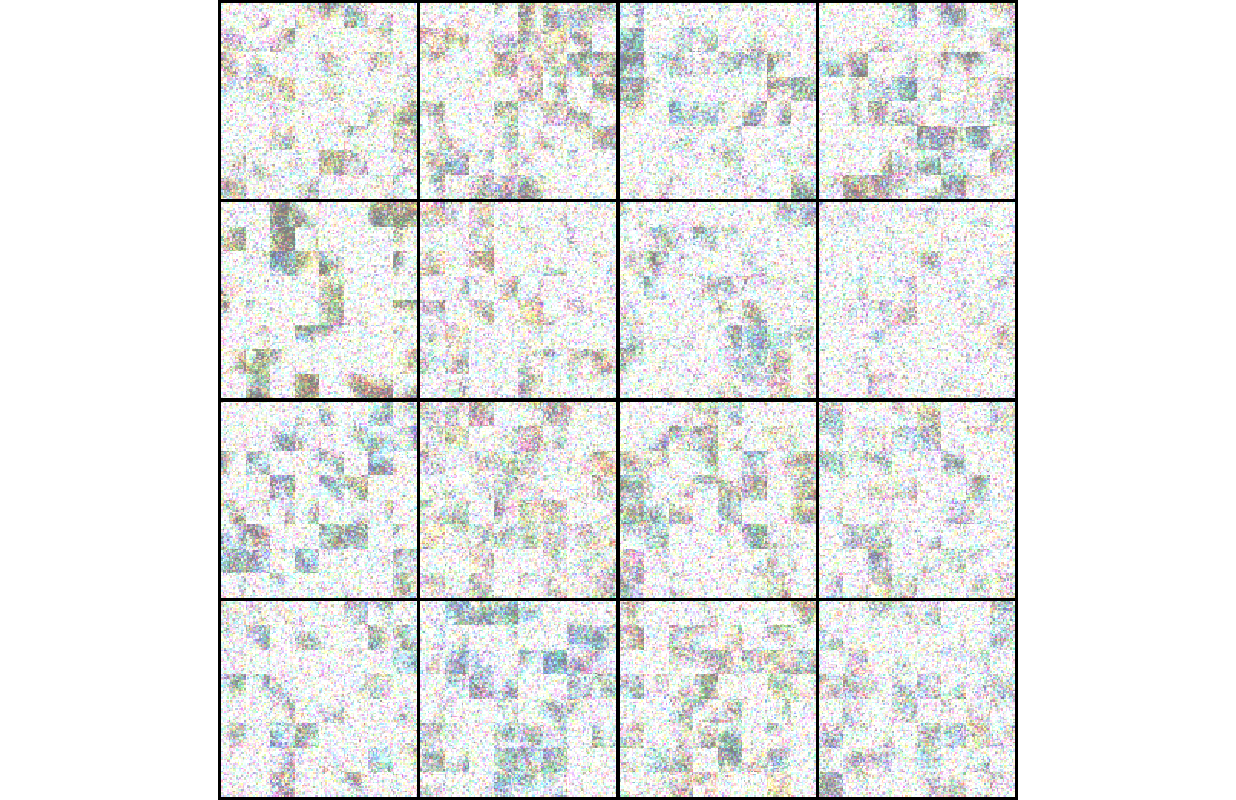

In [11]:
import torch
import numpy as np
import plotly.express as px
from torchvision.utils import make_grid
from IPython.display import display

def display_samples_plotly(samples, rows=4, cols=4):
    """
    Display samples in an interactive plotly grid
    
    Args:
        samples: Tensor of shape [N, C, H, W] in range [-1, 1]
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    """
    # Ensure we're working with normalized values
    samples = (samples + 1) * 0.5
    samples = samples.clamp(0, 1)
    
    # Convert to numpy and transpose to correct format
    samples = samples.cpu().numpy()
    samples = np.transpose(samples, (0, 2, 3, 1))
    
    # Create subplot grid
    fig = px.imshow(
        make_grid(torch.from_numpy(np.transpose(samples, (0, 3, 1, 2))), 
                 nrow=rows).permute(1, 2, 0).cpu().numpy(),
        title="Generated Samples"
    )
    
    # Update layout for better display
    fig.update_layout(
        width=800,
        height=800,
        showlegend=False,
        margin=dict(l=0, r=0, t=30, b=0)
    )
    
    # Remove axes
    fig.update_xaxes(showticklabels=False, showgrid=False)
    fig.update_yaxes(showticklabels=False, showgrid=False)
    
    fig.show()

def display_samples_grid(samples, rows=4, cols=4):
    """
    Alternative display using torchvision's make_grid
    
    Args:
        samples: Tensor of shape [N, C, H, W] in range [-1, 1]
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    """
    # Normalize to [0, 1]
    samples = (samples + 1) * 0.5
    samples = samples.clamp(0, 1)
    
    # Create grid
    grid = make_grid(samples, nrow=cols, padding=2, normalize=False)
    
    # Convert to plotly figure for better interaction
    fig = px.imshow(grid.permute(1, 2, 0).cpu().numpy())
    
    # Update layout
    fig.update_layout(
        width=800,
        height=800,
        showlegend=False,
        margin=dict(l=0, r=0, t=0, b=0)
    )
    
    # Remove axes
    fig.update_xaxes(showticklabels=False, showgrid=False)
    fig.update_yaxes(showticklabels=False, showgrid=False)
    
    fig.show()

display_samples_grid(samples)